In [38]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [39]:
smp = pd.read_csv("/kaggle/input/gia-smp-va-smpcap-2021-csv/Gia SMP va SMPcap 2021(Gia thi truong SMP).csv" , encoding='latin-1', sep=';' )

In [40]:
smp.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [41]:
feats = ['Ngày','15', '16','17']
smp[feats].head()

,Ngày,15,16,17
0,01/01/2021,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4
3,01/04/2021,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5


In [42]:
# Tạo một hàm để kiểm tra nếu 3 giá trị trong dòng là khác nhau
def is_unique(row):
    return len(set(row)) == len(row)

# Áp dụng hàm vào từng dòng của DataFrame
unique_rows = smp[feats].apply(is_unique, axis=1)

# Đếm số lượng dòng có giá trị khác nhau
num_unique_rows = unique_rows.sum()

print(f"Số lượng dòng có giá trị khác nhau trong 3 cột là: {num_unique_rows}")

Số lượng dòng có giá trị khác nhau trong 3 cột là: 0


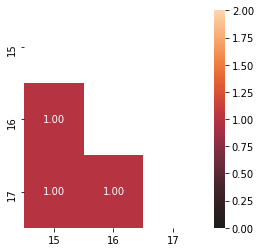

In [43]:
import seaborn as sns
mask = np.triu(np.ones_like(smp[feats].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(smp[feats].corr(), mask=mask, vmax=2, vmin=0, center=0,annot=True,fmt='.2f');

In [72]:
import pandas as pd
import plotly.graph_objects as go

# Ensure 'Ngày' column is of datetime type
df['Ngày'] = pd.to_datetime(df['Ngày'])

# Sort the DataFrame by the 'Ngày' column
df = df.sort_values(by='Ngày')

# Initialize the figure
fig = go.Figure()

# Loop through each column in the DataFrame (except the 'Ngày' column)
for column in df.columns:
    if column != 'Ngày':
        fig.add_trace(go.Scatter(x=df['Ngày'], y=df[column],
                                 mode='lines',
                                 name=f'Column {column}'))

# Update layout
fig.update_layout(
    xaxis_title="Ngày",
    yaxis_title="Values",
    title={'text': "Data", 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'}
)

# Show the plot
fig.show()


In [45]:
# smp = smp[feats]

In [46]:
!pip install filterpy

In [56]:
df = smp
smp = smp.drop(['Ngày'], axis =1)

In [55]:
smp = df

In [57]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(data):
    # Khởi tạo Kalman Filter
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.], [0.]])      
    kf.F = np.array([[1., 1.], [0., 1.]])  
    kf.H = np.array([[1., 0.]])         
    kf.P *= 1000.                        
    kf.R = 5                            
    kf.Q = np.array([[0.0001, 0.001], [0.001, 0.1]]) 

    predictions = []
    for z in data:
        kf.predict()
        kf.update([z])
        predictions.append(kf.x[0][0])

    return predictions


cols = smp.columns
for c in cols:
    smp[c] = apply_kalman_filter(smp[c])
print(smp.head())


             1            2            3            4            5  \
0   961.995013   961.995013   961.995013   961.995013   961.995013   
1  1023.799125  1023.799125  1023.799125  1023.799125  1023.799125   
2  1005.918162  1005.918162  1005.918162  1005.918162  1005.918162   
3  1008.124512  1008.124512  1008.124512  1008.124512  1008.124512   
4  1044.545952  1044.545952  1044.545952  1044.545952  1044.545952   

             6            7            8            9           10  ...  \
0   961.995013   961.995013   961.995013   961.995013   961.995013  ...   
1  1023.799125  1023.799125  1023.799125  1023.799125  1023.799125  ...   
2  1005.918162  1005.918162  1005.918162  1005.918162  1005.918162  ...   
3  1008.124512  1008.124512  1008.124512  1008.194603  1008.194603  ...   
4  1044.545952  1044.545952  1044.545952  1044.585533  1044.585533  ...   

            39           40           41           42           43  \
0   961.995013   961.995013   961.995013   961.995013   96

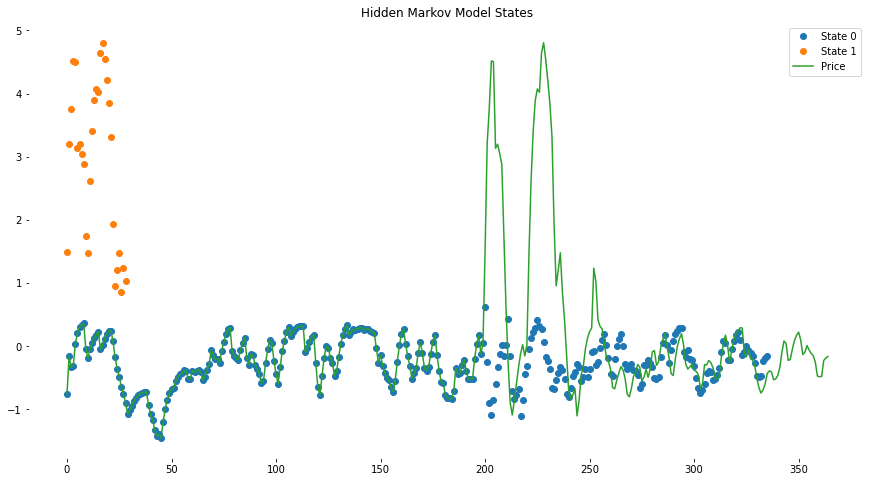

In [59]:
from hmmlearn import hmm
prices = smp.values
prices = (prices - np.mean(prices, axis=0)) / np.std(prices, axis=0)

# Define the HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)

# Fit the model
model.fit(prices)

# Predict hidden states
hidden_states = model.predict(prices)

# Plot the results
plt.figure(figsize=(15, 8))
for i in range(model.n_components):
    state = (hidden_states == i)
    plt.plot(prices[state, 0], 'o', label=f'State {i}')
plt.plot(prices[:, 0], label='Price')
plt.legend()
plt.title('Hidden Markov Model States')
plt.show()

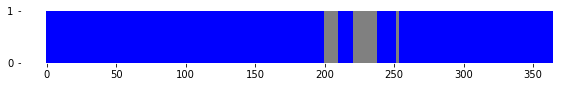

In [60]:
state2color = {} 
state2color['0'] = 'blue'
state2color['1'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[str(x)] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(hidden_states, state2color)

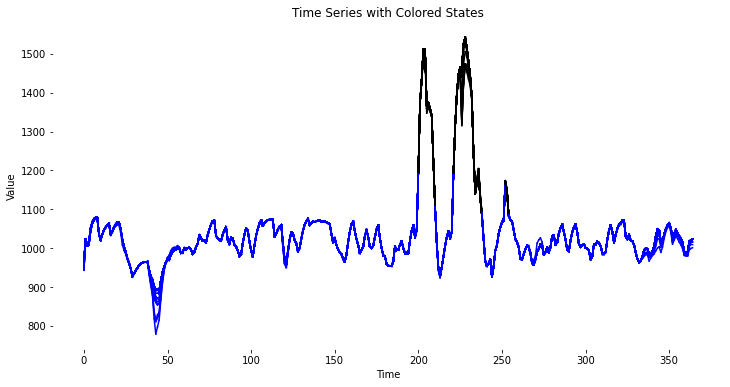

In [64]:
# Tạo một biểu đồ đường cho cột giá trị số thực
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ đường với màu sắc dựa trên giá trị số nguyên
for i in range(len(smp) - 1):
    plt.plot(smp.index[i:i+2], smp[i:i+2], color='blue' if hidden_states[i] == 0 else 'black')

# Thiết lập nhãn và tiêu đề
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Colored States')
plt.show()

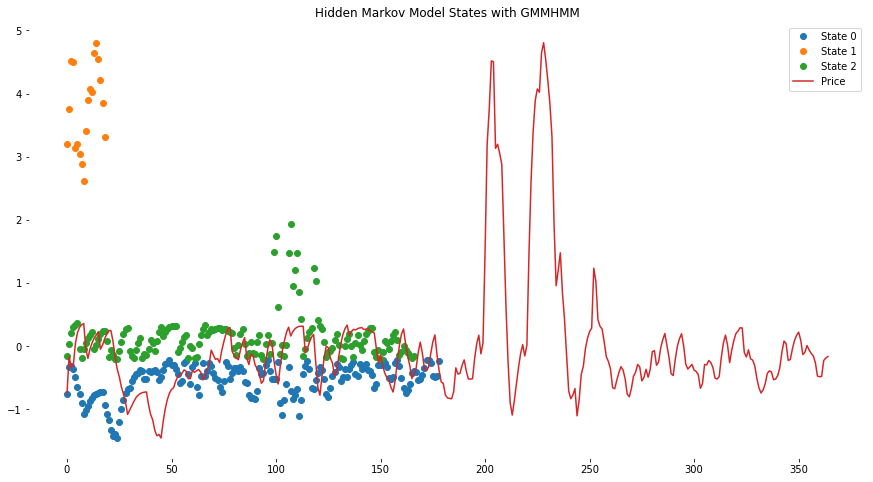

In [74]:

# Định nghĩa mô hình GMMHMM với 3 thành phần Gaussian
model = hmm.GMMHMM(n_components=3, n_mix=3, covariance_type="diag", n_iter=100)

# Khởi tạo ma trận chuyển trạng thái và xác suất ban đầu
model.startprob_ = np.array([0.5, 0.3, 0.2])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.2, 0.3, 0.5]])

# Huấn luyện mô hình
model.fit(prices)

# Dự đoán các trạng thái ẩn
hidden_states = model.predict(prices)

# Vẽ kết quả
plt.figure(figsize=(15, 8))
for i in range(model.n_components):
    state = (hidden_states == i)
    plt.plot(prices[state, 0], 'o', label=f'State {i}')
plt.plot(prices[:, 0], label='Price')
plt.legend()
plt.title('Hidden Markov Model States with GMMHMM')
plt.show()